# Alternative Tracing Methods

![AWTT](../../images/alternative_ways_to_trace_0.png)

So far in this module, we've taken a look at the traceable decorator, and how we can use it to set up tracing.

In this lesson, we're going to look at alternative ways in which we can set up tracing, and when you should think about using these different approaches.

## LangChain and LangGraph

If we are using LangChain or LangGraph, all we need to do to set up tracing is to set a few environment variables

![AWTT](../../images/alternative_ways_to_trace_1.png)

In [ ]:
# You can set them inline
import os
os.environ["OPENAI_API_KEY"] = ""
os.environ["LANGSMITH_API_KEY"] = ""
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langsmith-academy"  # If you don't set this, traces will go to the Default project

In [3]:
# Or you can use a .env file
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../.env", override=True)

True

Don't worry too much about our graph implementation here, you can learn more about LangGraph through our LangGraph Academy course!

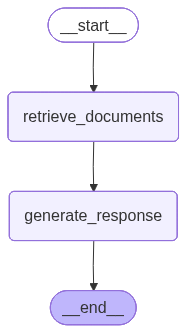

In [4]:
import nest_asyncio
import operator
from langchain.schema import Document
from langchain_core.messages import HumanMessage, AnyMessage, get_buffer_string
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing import List
from typing_extensions import TypedDict, Annotated
from utils import get_vector_db_retriever, RAG_PROMPT

nest_asyncio.apply()

retriever = get_vector_db_retriever()
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

# Define Graph state
class GraphState(TypedDict):
    question: str
    messages: Annotated[List[AnyMessage], operator.add]
    documents: List[Document]

# Define Nodes
def retrieve_documents(state: GraphState):
    messages = state.get("messages", [])
    question = state["question"]
    documents = retriever.invoke(f"{get_buffer_string(messages)} {question}")
    return {"documents": documents}

def generate_response(state: GraphState):
    question = state["question"]
    messages = state["messages"]
    documents = state["documents"]
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    
    rag_prompt_formatted = RAG_PROMPT.format(context=formatted_docs, conversation=messages, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"documents": documents, "messages": [HumanMessage(question), generation]}

# Define Graph
graph_builder = StateGraph(GraphState)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)
graph_builder.add_edge(START, "retrieve_documents")
graph_builder.add_edge("retrieve_documents", "generate_response")
graph_builder.add_edge("generate_response", END)

simple_rag_graph = graph_builder.compile()
display(Image(simple_rag_graph.get_graph().draw_mermaid_png()))

We're setting up a simple graph in LangGraph. If you want to learn more about LangGraph, I would highly recommend taking a look at our LangGraph Academy course.

You can also pass in metadata or other fields through an optional config

In [5]:
question = "What are the different types of jutsu that Naruto can perform?"
simple_rag_graph.invoke({"question": question}, config={"metadata": {"anime": "naruto", "character_focus": "uzumaki_naruto"}})

{'question': 'What are the different types of jutsu that Naruto can perform?',
 'messages': [HumanMessage(content='What are the different types of jutsu that Naruto can perform?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I don't know.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 4, 'prompt_tokens': 489, 'total_tokens': 493, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CMwVgpnz6YFGNq3REbHk8J6Oid3fm', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--6f3f62b2-c19d-4f56-b258-c95a23b47a72-0', usage_metadata={'input_tokens': 489, 'output_tokens': 4, 'total_tokens': 493, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token

##### Let's take a look in LangSmith!

## Tracing Context Manager

In Python, you can use the trace context manager to log traces to LangSmith. This is useful in situations where:

You want to log traces for a specific block of code.
You want control over the inputs, outputs, and other attributes of the trace.
It is not feasible to use a decorator or wrapper.
Any or all of the above.
The context manager integrates seamlessly with the traceable decorator and wrap_openai wrapper, so you can use them together in the same application.

You still need to set your `LANGSMITH_API_KEY` and `LANGSMITH_TRACING`

![AWTT](../../images/alternative_ways_to_trace_2.png)

In [6]:
from langsmith import traceable, trace
from openai import OpenAI
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

MODEL_PROVIDER = "openai"
MODEL_NAME = "gpt-4o-mini"
APP_VERSION = 2.0  # Updated for Naruto-themed implementation
NARUTO_SYSTEM_PROMPT = """You are a knowledgeable ninja assistant from the Hidden Leaf Village. 
Use the following pieces of retrieved context to answer questions about the ninja world. 
If you don't know the answer, just say "That's beyond my ninja knowledge, dattebayo!" 
Use three sentences maximum and keep the answer concise like a true shinobi.
"""

openai_client = OpenAI()
nest_asyncio.apply()
retriever = get_vector_db_retriever()

"""
retrieve_ninja_intel
- Returns documents fetched from the ninja archives based on the user's question
"""
@traceable(metadata={"village": "hidden_leaf", "rank": "chunin"})
def retrieve_ninja_intel(question: str):
    documents = retriever.invoke(question)
    return documents

"""
generate_ninja_response
- Calls `call_hokage_council` to generate a response after formatting ninja intel
"""
# TODO: Remove traceable, and use with trace()
@traceable(metadata={"jutsu_type": "information_gathering"})
def generate_ninja_response(question: str, documents):
    # NOTE: Our documents came in as a list of objects, but we just want to log a string
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)

    # TODO: Use with trace()
    # with trace(
    #     name="Generate Ninja Response",
    #     run_type="chain", 
    #     inputs={"question": question, "formatted_docs": formatted_docs},
    #     metadata={"village": "hidden_leaf", "ninja_technique": "intelligence_analysis"},
    # ) as ls_trace:
    messages = [
        {
            "role": "system",
            "content": NARUTO_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Ninja Intel: {formatted_docs} \n\n Shinobi Question: {question}"
        }
    ]
    response = call_hokage_council(messages)
    # TODO: End your trace and write outputs to LangSmith
    # ls_trace.end(outputs={"ninja_response": response})
    return response

"""
call_hokage_council
- Returns the wisdom from the Hokage's council (OpenAI chat completion)
"""
@traceable(metadata={"council": "hokage", "village": "konoha"})
def call_hokage_council(
    messages: List[dict], model: str = MODEL_NAME, temperature: float = 0.1  # Slightly higher for ninja creativity
) -> str:
    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )
    return response

"""
ninja_knowledge_system
- Calls `retrieve_ninja_intel` to fetch documents from ninja archives
- Calls `generate_ninja_response` to generate a response based on the fetched intel
- Returns the ninja wisdom
"""
@traceable(metadata={"system": "ninja_knowledge", "creator": "akshat_ninja"})
def ninja_knowledge_system(question: str):
    documents = retrieve_ninja_intel(question)
    response = generate_ninja_response(question, documents)
    return response.choices[0].message.content

In [7]:
question = "What is the difference between the Rasengan and the Chidori techniques?"
ai_answer = ninja_knowledge_system(question)
print(ai_answer)

The Rasengan is a spinning sphere of chakra created by the user, requiring precise chakra control and is known for its destructive power. In contrast, the Chidori is a lightning-based technique that channels electrical chakra into the user's hand, allowing for high-speed thrust attacks. Both techniques are signature moves of Naruto and Sasuke, respectively, showcasing their unique styles and abilities.


## wrap_openai

The wrap_openai/wrapOpenAI methods in Python/TypeScript allow you to wrap your OpenAI client in order to automatically log traces -- no decorator or function wrapping required! The wrapper works seamlessly with the @traceable decorator or traceable function and you can use both in the same application.

You still need to set your `LANGSMITH_API_KEY` and `LANGSMITH_TRACING`

![AWTT](../../images/alternative_ways_to_trace_3.png)

In [11]:
# TODO: Import wrap_openai
from langsmith.wrappers import wrap_openai
import openai
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

MODEL_PROVIDER = "openai"
MODEL_NAME = "gpt-4o-mini"
APP_VERSION = 2.0
NARUTO_SAGE_PROMPT = """You are a wise sage from Mount Myoboku with vast knowledge of the ninja world. 
Use the following pieces of retrieved context to answer questions about jutsu, chakra, and ninja techniques. 
If you don't know the answer, just say "Even the great toads don't know everything, young ninja." 
Use three sentences maximum and keep the answer concise like a true sage.
"""

# TODO: Wrap the OpenAI Client
openai_client = wrap_openai(openai.Client())

nest_asyncio.apply()
retriever = get_vector_db_retriever()

@traceable(run_type="chain", metadata={"technique": "sage_retrieval", "location": "mount_myoboku"})
def retrieve_sage_knowledge(question: str):
    return retriever.invoke(question)

@traceable(run_type="chain", metadata={"sage_mode": "active", "wisdom_level": "elder"})
def generate_sage_wisdom(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "system",
            "content": NARUTO_SAGE_PROMPT
        },
        {
            "role": "user",
            "content": f"Ancient Knowledge: {formatted_docs} \n\n Young Ninja's Question: {question}"
        }
    ]
    # TODO: We don't need to use @traceable on a nested function call anymore,
    # wrap_openai takes care of this for us
    return call_great_toad_sage(messages)

@traceable(metadata={"sage": "great_toad_sage", "chakra": "natural_energy"})
def call_great_toad_sage(
    messages: List[dict],
) -> str:
    return openai_client.chat.completions.create(
        model=MODEL_NAME,
        messages=messages,
        temperature=0.15,  # Sage wisdom should be consistent yet slightly creative
    )

@traceable(run_type="chain", metadata={"system": "sage_wisdom", "mount": "myoboku"})
def sage_wisdom_system(question: str):
    documents = retrieve_sage_knowledge(question)
    response = generate_sage_wisdom(question, documents)
    return response.choices[0].message.content

In [9]:
question = "How does Sage Mode enhance a ninja's abilities?"
ai_answer = sage_wisdom_system(question)
print(ai_answer)

Sage Mode allows a ninja to tap into natural energy, significantly enhancing their physical abilities, sensory perception, and jutsu potency. This transformation grants them heightened reflexes and strength, as well as the ability to sense chakra from great distances. Additionally, it enables the user to perform powerful techniques that are otherwise unattainable in their normal state.


The wrapped OpenAI client accepts all the same langsmith_extra parameters as @traceable decorated functions

In [12]:
messages = [
    {
        "role": "user",
        "content": "What are the Nine-Tailed Fox's powers?"
    }
]

openai_client.chat.completions.create(
    model=MODEL_NAME,
    messages=messages,
    langsmith_extra={"metadata": {"bijuu": "nine_tails", "chakra_type": "demonic"}},
)

ChatCompletion(id='chatcmpl-CMwYVuUhHa7nduM8hWWtNav1Avgqp', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The Nine-Tailed Fox, often referred to as the "Kitsune" in Japanese folklore and the "Kumiho" in Korean folklore, is a mythical creature that possesses a variety of supernatural powers and abilities. Here are some of the powers commonly attributed to the Nine-Tailed Fox:\n\n1. **Shape-shifting**: The Nine-Tailed Fox can change its form, often transforming into a beautiful woman or other creatures to deceive or seduce humans.\n\n2. **Illusion Creation**: It can create powerful illusions, making people see or experience things that are not real, which it uses to mislead or trick people.\n\n3. **Immortality**: In many versions of the myth, the Nine-Tailed Fox possesses a form of immortality, living for thousands of years and gaining wisdom over time.\n\n4. **Enhanced Agility and Speed**: The creature is often depicted as being ext

## [Advanced] RunTree

Another, more explicit way to log traces to LangSmith is via the RunTree API. This API allows you more control over your tracing - you can manually create runs and children runs to assemble your trace. You still need to set your `LANGSMITH_API_KEY`, but `LANGSMITH_TRACING` is not necessary for this method.

![AWTT](../../images/alternative_ways_to_trace_4.png)

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = ""
os.environ["LANGSMITH_API_KEY"] = ""
os.environ["LANGSMITH_PROJECT"] = "langsmith-academy"

In [13]:
from dotenv import load_dotenv
# I have my env variables defined in a .env file
load_dotenv(dotenv_path="../../.env", override=True)

True

Let's go ahead and set `LANGSMITH_TRACING` to false, as we are using RunTree to manually create runs in this case.

In [14]:
import os
os.environ["LANGSMITH_TRACING"] = "false"

from langsmith import utils
utils.tracing_is_enabled() # This should return false

True

We have rewritten our RAG application, except this time we pass a RunTree argument through our function calls, and create child runs at each layer. This gives our RunTree the same hierarchy that we were automatically able to establish with @traceable

In [18]:
from langsmith import RunTree
from openai import OpenAI
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

openai_client = OpenAI()
nest_asyncio.apply()
retriever = get_vector_db_retriever()

def retrieve_shinobi_scrolls(parent_run: RunTree, question: str):
    # Create a child run
    child_run = parent_run.create_child(
        name="Retrieve Shinobi Scrolls",
        run_type="retriever",
        inputs={"question": question}
    )
    # Set metadata after creation
    child_run.extra = {"scroll_type": "forbidden_jutsu", "village": "hidden_leaf"}
    documents = retriever.invoke(question)
    # Post the output of our child run
    child_run.end(outputs={"scrolls": documents})
    child_run.post()
    return documents

def generate_hokage_wisdom(parent_run: RunTree, question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    hokage_system_prompt = """You are the Seventh Hokage, Naruto Uzumaki, sharing your wisdom with fellow shinobi. 
    Use the following pieces of retrieved context to answer questions about the ninja way. 
    If you don't know the answer, just say "I'm still learning too, dattebayo!" 
    Use three sentences maximum and keep the answer encouraging like a true Hokage.
    """
    # Create a child run
    child_run = parent_run.create_child(
        name="Generate Hokage Wisdom",
        run_type="chain",
        inputs={"question": question, "documents": documents}
    )
    # Set metadata after creation
    child_run.extra = {"hokage": "seventh", "technique": "will_of_fire"}
    messages = [
        {
            "role": "system",
            "content": hokage_system_prompt
        },
        {
            "role": "user",
            "content": f"Shinobi Knowledge: {formatted_docs} \n\n Fellow Ninja's Question: {question}"
        }
    ]
    openai_response = call_shadow_clone_jutsu(child_run, messages)
    # Post the output of our child run
    child_run.end(outputs={"hokage_wisdom": openai_response})
    child_run.post()
    return openai_response

def call_shadow_clone_jutsu(
    parent_run: RunTree, messages: List[dict], model: str = "gpt-4o-mini", temperature: float = 0.2
) -> str:
    # Create a child run
    child_run = parent_run.create_child(
        name="Shadow Clone Jutsu",
        run_type="llm",
        inputs={"messages": messages}
    )
    # Set metadata after creation
    child_run.extra = {"jutsu": "kage_bunshin", "chakra_cost": "medium"}
    openai_response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )
    # Post the output of our child run
    child_run.end(outputs={"clone_response": openai_response})
    child_run.post()
    return openai_response

def hokage_guidance_system(question: str):
    # Create a root RunTree
    root_run_tree = RunTree(
        name="Hokage Guidance Pipeline",
        run_type="chain",
        inputs={"question": question}
    )
    # Set metadata after creation
    root_run_tree.extra = {"system": "hokage_office", "village": "konohagakure"}

    # Pass our RunTree into the nested function calls
    documents = retrieve_shinobi_scrolls(root_run_tree, question)
    response = generate_hokage_wisdom(root_run_tree, question, documents)
    output = response.choices[0].message.content

    # Post our final output
    root_run_tree.end(outputs={"hokage_guidance": output})
    root_run_tree.post()
    return output

In [19]:
question = "What does it mean to follow the Will of Fire?"
ai_answer = hokage_guidance_system(question)
print(ai_answer)

The Will of Fire represents the belief that love and bonds between people are the foundation of a strong village. It teaches us to protect and support one another, ensuring that the next generation can thrive. Embrace this spirit, and you'll always find strength in your connections, dattebayo!
